In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
import scipy.optimize as opt

from simpledbf import Dbf5

from factor_analyzer.factor_analyzer import FactorAnalyzer
from pingouin import cronbach_alpha
import sklearn.linear_model as lm
from sklearn.feature_selection import r_regression
from sklearn.model_selection import train_test_split, KFold

import requests
import csv
import json

In [3]:
## Limitations:
### Madera County shenanigans (see SWDB website)

In [4]:
data = pd.read_csv('transformed_data/all_results.csv')
data.head()

,SRPREC_KEY,PR_1_N,PR_1_Y,PR_26_N,PR_26_Y,PR_27_N,PR_27_Y,PR_28_N,PR_28_Y,PR_29_N,...,PRSLIB01,PRSPAF01,SENDEM01,SENDEM02,SENREP01,SENREP02,USPDEM01,USPREP01,USSDEM01,USSREP01
0,06001200100,110.394301,2391.379349,1861.799846,628.266515,2280.397404,265.628899,393.789849,2191.582654,1613.914273,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,06001200200,84.131590,1476.736304,1153.935857,417.466221,1457.753361,152.717510,250.142427,1362.003012,1017.075146,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,06001201400,103.578871,2247.796796,1672.623802,662.821849,2142.791281,254.711844,352.495938,2077.982694,1402.019259,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,06001202200,23.911917,251.075125,172.365066,102.621975,229.155868,49.816493,45.831174,236.130177,149.449479,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,06001202500,21.736580,229.559095,124.916878,126.381705,200.960005,60.204696,28.722699,235.426705,117.895858,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
# data = pd.read_csv("data/state_g24_sov_data_by_g24_svprec.csv")
# data.head()

In [6]:
data.shape

(20060, 156)

In [7]:
full_data = data.copy()
full_data.shape

(20060, 156)

In [8]:
# data['SRPREC'].map(lambda x: x[:3])

In [9]:
# data = data[(data['SVPREC'].map(lambda x: x[-3:]) != 'TOT') &
#     (data['SVPREC'].map(lambda x: x[:3] != 'SOV'))]

In [10]:
data.columns.values

array(['SRPREC_KEY', 'PR_1_N', 'PR_1_Y', 'PR_26_N', 'PR_26_Y', 'PR_27_N',
       'PR_27_Y', 'PR_28_N', 'PR_28_Y', 'PR_29_N', 'PR_29_Y', 'PR_30_N',
       'PR_30_Y', 'PR_31_N', 'PR_31_Y', 'PR_1_TOT', 'PR_26_TOT',
       'PR_27_TOT', 'PR_28_TOT', 'PR_29_TOT', 'PR_30_TOT', 'PR_31_TOT',
       'CIT_23', 'NH_CIT_23', 'NH_Ind_CIT_23', 'NH_Asn_CIT_23',
       'NH_Blk_CIT_23', 'NH_Hwn_CIT_23', 'NH_Wht_CIT_23',
       'NH_IndWht_CIT_23', 'NH_AsnWht_CIT_23', 'NH_BlkWht_CIT_23',
       'NH_IndBlk_CIT_23', 'NH_OthMR_CIT_23', 'Hsp_CIT_23', 'CVAP_23',
       'NH_CVAP_23', 'NH_Ind_CVAP_23', 'NH_Asn_CVAP_23', 'NH_Blk_CVAP_23',
       'NH_Hwn_CVAP_23', 'NH_Wht_CVAP_23', 'NH_IndWht_CVAP_23',
       'NH_AsnWht_CVAP_23', 'NH_BlkWht_CVAP_23', 'NH_IndBlk_CVAP_23',
       'NH_OthMR_CVAP_23', 'Hsp_CVAP_23', 'DOJ_NH_Ind_CIT_23',
       'DOJ_NH_Ind_CVAP_23', 'DOJ_NH_Blk_CIT_23', 'DOJ_NH_Blk_CVAP_23',
       'DOJ_NH_Asn_CIT_23', 'DOJ_NH_Asn_CVAP_23', 'SRPREC', 'COUNTY',
       'FIPS_CODE', 'G24PDem', 'G24PRep', 

In [11]:
data.shape

(20060, 156)

In [12]:
data = data.rename({
    'SRPREC_KEY': 'SVPREC_KEY',
    'G24PDem': 'PRSDEM01',
    'G24PRep': 'PRSREP01',
    'G24POth': 'PRSOTH01',
    'G24PTot': 'pres_tot',
    'G24SDem': 'SENDEM01',
    'G24SRep': 'SENREP01',
    'G24STot': 'sen_tot'
}, axis=1)

for i in [2, 3, 4, 5, 6, 32, 33, 34, 35, 36]:
    data = data.rename({
        f'G24PR{i}_N': f'PR_{i}_N',
        f'G24PR{i}_Y': f'PR_{i}_Y'
    }, axis=1)

data.columns.values

array(['SVPREC_KEY', 'PR_1_N', 'PR_1_Y', 'PR_26_N', 'PR_26_Y', 'PR_27_N',
       'PR_27_Y', 'PR_28_N', 'PR_28_Y', 'PR_29_N', 'PR_29_Y', 'PR_30_N',
       'PR_30_Y', 'PR_31_N', 'PR_31_Y', 'PR_1_TOT', 'PR_26_TOT',
       'PR_27_TOT', 'PR_28_TOT', 'PR_29_TOT', 'PR_30_TOT', 'PR_31_TOT',
       'CIT_23', 'NH_CIT_23', 'NH_Ind_CIT_23', 'NH_Asn_CIT_23',
       'NH_Blk_CIT_23', 'NH_Hwn_CIT_23', 'NH_Wht_CIT_23',
       'NH_IndWht_CIT_23', 'NH_AsnWht_CIT_23', 'NH_BlkWht_CIT_23',
       'NH_IndBlk_CIT_23', 'NH_OthMR_CIT_23', 'Hsp_CIT_23', 'CVAP_23',
       'NH_CVAP_23', 'NH_Ind_CVAP_23', 'NH_Asn_CVAP_23', 'NH_Blk_CVAP_23',
       'NH_Hwn_CVAP_23', 'NH_Wht_CVAP_23', 'NH_IndWht_CVAP_23',
       'NH_AsnWht_CVAP_23', 'NH_BlkWht_CVAP_23', 'NH_IndBlk_CVAP_23',
       'NH_OthMR_CVAP_23', 'Hsp_CVAP_23', 'DOJ_NH_Ind_CIT_23',
       'DOJ_NH_Ind_CVAP_23', 'DOJ_NH_Blk_CIT_23', 'DOJ_NH_Blk_CVAP_23',
       'DOJ_NH_Asn_CIT_23', 'DOJ_NH_Asn_CVAP_23', 'SRPREC', 'COUNTY',
       'FIPS_CODE', 'PRSDEM01', 'PRSREP01'

In [13]:
# data = data[~data[['PR_2_N', 'PR_2_Y', 'PR_32_N',
#        'PR_32_Y', 'PR_33_N', 'PR_33_Y', 'PR_34_N', 'PR_34_Y', 'PR_35_N',
#        'PR_35_Y', 'PR_36_N', 'PR_36_Y', 'PR_3_N', 'PR_3_Y', 'PR_4_N',
#        'PR_4_Y', 'PR_5_N', 'PR_5_Y', 'PR_6_N', 'PR_6_Y']].isna()]

In [14]:
cols = [
    'SVPREC_KEY', 'PR_2_N', 'PR_2_Y', 'PR_32_N',
       'PR_32_Y', 'PR_33_N', 'PR_33_Y', 'PR_34_N', 'PR_34_Y', 'PR_35_N',
       'PR_35_Y', 'PR_36_N', 'PR_36_Y', 'PR_3_N', 'PR_3_Y', 'PR_4_N',
       'PR_4_Y', 'PR_5_N', 'PR_5_Y', 'PR_6_N', 'PR_6_Y', 'PRSDEM01',
       'PRSOTH01', 'PRSREP01', 'pres_tot', 'SENDEM01', 'SENREP01', 'sen_tot',
    'PR_1_N', 'PR_1_Y', 'PR_26_N', 'PR_26_Y', 'PR_27_N', 'PR_27_Y',
       'PR_28_N', 'PR_28_Y', 'PR_29_N', 'PR_29_Y', 'PR_30_N', 'PR_30_Y',
       'PR_31_N', 'PR_31_Y', 'CIT_23', 'NH_CIT_23', 'NH_Ind_CIT_23', 'NH_Asn_CIT_23',
       'NH_Blk_CIT_23', 'NH_Hwn_CIT_23', 'NH_Wht_CIT_23',
       'NH_IndWht_CIT_23', 'NH_AsnWht_CIT_23', 'NH_BlkWht_CIT_23',
       'NH_IndBlk_CIT_23', 'NH_OthMR_CIT_23', 'Hsp_CIT_23', 'CVAP_23',
       'NH_CVAP_23', 'NH_Ind_CVAP_23', 'NH_Asn_CVAP_23', 'NH_Blk_CVAP_23',
       'NH_Hwn_CVAP_23', 'NH_Wht_CVAP_23', 'NH_IndWht_CVAP_23',
       'NH_AsnWht_CVAP_23', 'NH_BlkWht_CVAP_23', 'NH_IndBlk_CVAP_23',
       'NH_OthMR_CVAP_23', 'Hsp_CVAP_23', 'DOJ_NH_Ind_CIT_23',
       'DOJ_NH_Ind_CVAP_23', 'DOJ_NH_Blk_CIT_23', 'DOJ_NH_Blk_CVAP_23',
       'DOJ_NH_Asn_CIT_23', 'DOJ_NH_Asn_CVAP_23'
]

data = data[cols]
data.head()

,SVPREC_KEY,PR_2_N,PR_2_Y,PR_32_N,PR_32_Y,PR_33_N,PR_33_Y,PR_34_N,PR_34_Y,PR_35_N,...,NH_BlkWht_CVAP_23,NH_IndBlk_CVAP_23,NH_OthMR_CVAP_23,Hsp_CVAP_23,DOJ_NH_Ind_CIT_23,DOJ_NH_Ind_CVAP_23,DOJ_NH_Blk_CIT_23,DOJ_NH_Blk_CVAP_23,DOJ_NH_Asn_CIT_23,DOJ_NH_Asn_CVAP_23
0,06001200100,551,2325,714,2114,1910,870,1608,1078,635,...,49,0,13,165,4,4,133,122,700,551
1,06001200200,387,1581,494,1448,1197,710,1148,706,464,...,2,12,9,410,17,17,212,163,1167,1079
2,06001201400,438,2457,610,2260,1633,1186,1659,1037,621,...,13,18,13,565,21,21,184,166,1350,1224
3,06001202200,62,344,74,323,157,226,232,140,77,...,3,5,7,54,0,0,22,21,223,213
4,06001202500,90,539,148,468,212,389,307,280,111,...,14,0,15,810,62,62,183,183,1408,1374


In [15]:

data = data[(~data['PR_2_Y'].isna()) & 
    (~data['PR_3_Y'].isna()) &
    (~data['PR_4_Y'].isna()) &
    (~data['PR_32_Y'].isna()) &
    (~data['PR_35_Y'].isna()) &
    (~data['PR_26_Y'].isna()) &
    (~data['PR_1_Y'].isna()) &
    (~data['PR_30_Y'].isna()) &
    (~data['PR_27_Y'].isna()) & (~data['PR_2_Y'].isna()) & 
    (~data['PR_3_Y'].isna()) &
    (~data['PR_4_Y'].isna()) &
    (~data['PR_32_Y'].isna()) &
    (~data['PR_35_Y'].isna()) &
    (~data['PR_26_Y'].isna()) &
    (~data['PR_1_Y'].isna()) &
    (~data['PR_30_Y'].isna()) &
    (~data['PR_27_Y'].isna()) & (~data['PRSDEM01'].isna())]
data.shape

(20060, 76)

In [16]:
data.isin([-np.inf, np.inf]).any()

SVPREC_KEY            False
PR_2_N                False
PR_2_Y                False
PR_32_N               False
PR_32_Y               False
                      ...  
DOJ_NH_Ind_CVAP_23    False
DOJ_NH_Blk_CIT_23     False
DOJ_NH_Blk_CVAP_23    False
DOJ_NH_Asn_CIT_23     False
DOJ_NH_Asn_CVAP_23    False
Length: 76, dtype: bool

In [17]:
data.head()

,SVPREC_KEY,PR_2_N,PR_2_Y,PR_32_N,PR_32_Y,PR_33_N,PR_33_Y,PR_34_N,PR_34_Y,PR_35_N,...,NH_BlkWht_CVAP_23,NH_IndBlk_CVAP_23,NH_OthMR_CVAP_23,Hsp_CVAP_23,DOJ_NH_Ind_CIT_23,DOJ_NH_Ind_CVAP_23,DOJ_NH_Blk_CIT_23,DOJ_NH_Blk_CVAP_23,DOJ_NH_Asn_CIT_23,DOJ_NH_Asn_CVAP_23
0,06001200100,551,2325,714,2114,1910,870,1608,1078,635,...,49,0,13,165,4,4,133,122,700,551
1,06001200200,387,1581,494,1448,1197,710,1148,706,464,...,2,12,9,410,17,17,212,163,1167,1079
2,06001201400,438,2457,610,2260,1633,1186,1659,1037,621,...,13,18,13,565,21,21,184,166,1350,1224
3,06001202200,62,344,74,323,157,226,232,140,77,...,3,5,7,54,0,0,22,21,223,213
4,06001202500,90,539,148,468,212,389,307,280,111,...,14,0,15,810,62,62,183,183,1408,1374


In [18]:
prop_cols = ['PR_2', 'PR_32', 'PR_33', 'PR_34', 'PR_35', 'PR_4', 'PR_36', 'PR_3', 'PR_5', 'PR_6', 
             'PR_1', 'PR_26', 'PR_27', 'PR_28', 'PR_29', 'PR_30', 'PR_31']

for prop in prop_cols:
    data[f'{prop}_Y'] = pd.to_numeric(data[f'{prop}_Y'].replace({'***':0}), errors='coerce')
    data[f'{prop}_N'] = pd.to_numeric(data[f'{prop}_N'].replace({'***':0}), errors='coerce')
    data[f'{prop}_Y'] = data[f'{prop}_Y'] / (data[f'{prop}_Y'] + data[f'{prop}_N'])
    data = data.drop([f'{prop}_N'], axis='columns')

data.head()

,SVPREC_KEY,PR_2_Y,PR_32_Y,PR_33_Y,PR_34_Y,PR_35_Y,PR_36_Y,PR_3_Y,PR_4_Y,PR_5_Y,...,NH_BlkWht_CVAP_23,NH_IndBlk_CVAP_23,NH_OthMR_CVAP_23,Hsp_CVAP_23,DOJ_NH_Ind_CIT_23,DOJ_NH_Ind_CVAP_23,DOJ_NH_Blk_CIT_23,DOJ_NH_Blk_CVAP_23,DOJ_NH_Asn_CIT_23,DOJ_NH_Asn_CVAP_23
0,06001200100,0.808414,0.747525,0.312950,0.401340,0.773941,0.478416,0.936986,0.851100,0.629434,...,49,0,13,165,4,4,133,122,700,551
1,06001200200,0.803354,0.745623,0.372313,0.380798,0.757449,0.462141,0.929746,0.845148,0.653230,...,2,12,9,410,17,17,212,163,1167,1079
2,06001201400,0.848705,0.787456,0.420717,0.384644,0.778610,0.424189,0.936925,0.874056,0.718925,...,13,18,13,565,21,21,184,166,1350,1224
3,06001202200,0.847291,0.813602,0.590078,0.376344,0.798956,0.367609,0.911111,0.863184,0.760101,...,3,5,7,54,0,0,22,21,223,213
4,06001202500,0.856916,0.759740,0.647255,0.477002,0.818923,0.385484,0.910494,0.899371,0.786624,...,14,0,15,810,62,62,183,183,1408,1374


In [19]:
pres_cols = ['PRSDEM01', 'PRSREP01', 'PRSOTH01']

for cand in pres_cols:
    data[cand] = data[cand].replace({'***':0}).astype(int)
    data[cand] = data[cand] / data['pres_tot']

data = data.drop(['pres_tot'], axis='columns')
data.head()

,SVPREC_KEY,PR_2_Y,PR_32_Y,PR_33_Y,PR_34_Y,PR_35_Y,PR_36_Y,PR_3_Y,PR_4_Y,PR_5_Y,...,NH_BlkWht_CVAP_23,NH_IndBlk_CVAP_23,NH_OthMR_CVAP_23,Hsp_CVAP_23,DOJ_NH_Ind_CIT_23,DOJ_NH_Ind_CVAP_23,DOJ_NH_Blk_CIT_23,DOJ_NH_Blk_CVAP_23,DOJ_NH_Asn_CIT_23,DOJ_NH_Asn_CVAP_23
0,06001200100,0.808414,0.747525,0.312950,0.401340,0.773941,0.478416,0.936986,0.851100,0.629434,...,49,0,13,165,4,4,133,122,700,551
1,06001200200,0.803354,0.745623,0.372313,0.380798,0.757449,0.462141,0.929746,0.845148,0.653230,...,2,12,9,410,17,17,212,163,1167,1079
2,06001201400,0.848705,0.787456,0.420717,0.384644,0.778610,0.424189,0.936925,0.874056,0.718925,...,13,18,13,565,21,21,184,166,1350,1224
3,06001202200,0.847291,0.813602,0.590078,0.376344,0.798956,0.367609,0.911111,0.863184,0.760101,...,3,5,7,54,0,0,22,21,223,213
4,06001202500,0.856916,0.759740,0.647255,0.477002,0.818923,0.385484,0.910494,0.899371,0.786624,...,14,0,15,810,62,62,183,183,1408,1374


In [20]:
# sen_cols = ['SENDEM01', 'SENREP01']

# for cand in sen_cols:
#     data[cand] = data[cand].replace({'***':0}).astype(int)
#     data[cand] = data[cand] / data['sen_tot']

# data = data.drop(['sen_tot'], axis='columns')
# data.head()

In [21]:
data = data.set_index(['SVPREC_KEY'])
data.head(1)

,PR_2_Y,PR_32_Y,PR_33_Y,PR_34_Y,PR_35_Y,PR_36_Y,PR_3_Y,PR_4_Y,PR_5_Y,PR_6_Y,...,NH_BlkWht_CVAP_23,NH_IndBlk_CVAP_23,NH_OthMR_CVAP_23,Hsp_CVAP_23,DOJ_NH_Ind_CIT_23,DOJ_NH_Ind_CVAP_23,DOJ_NH_Blk_CIT_23,DOJ_NH_Blk_CVAP_23,DOJ_NH_Asn_CIT_23,DOJ_NH_Asn_CVAP_23
SVPREC_KEY,,,,,,,,,,,,,,,,,,,,,
06001200100,0.808414,0.747525,0.31295,0.40134,0.773941,0.478416,0.936986,0.8511,0.629434,0.754941,...,49,0,13,165,4,4,133,122,700,551


In [22]:
data[data.index.map(lambda x: x[:5]) == '06039']

,PR_2_Y,PR_32_Y,PR_33_Y,PR_34_Y,PR_35_Y,PR_36_Y,PR_3_Y,PR_4_Y,PR_5_Y,PR_6_Y,...,NH_BlkWht_CVAP_23,NH_IndBlk_CVAP_23,NH_OthMR_CVAP_23,Hsp_CVAP_23,DOJ_NH_Ind_CIT_23,DOJ_NH_Ind_CVAP_23,DOJ_NH_Blk_CIT_23,DOJ_NH_Blk_CVAP_23,DOJ_NH_Asn_CIT_23,DOJ_NH_Asn_CVAP_23
SVPREC_KEY,,,,,,,,,,,,,,,,,,,,,
060391003,0.489104,0.276618,0.281700,0.524443,0.573197,0.799370,0.450209,0.456619,0.251046,0.267229,...,0,0,0,467,64,52,62,33,109,66
060391020,0.340476,0.203002,0.217460,0.468344,0.446043,0.833466,0.322115,0.329365,0.184127,0.180367,...,0,0,0,639,55,55,50,0,123,90
060391027,0.360525,0.232700,0.246873,0.481925,0.480943,0.821631,0.358184,0.360721,0.229201,0.220019,...,0,0,4,2022,303,207,48,27,371,287
060391031,0.382716,0.225000,0.271605,0.386667,0.469136,0.728395,0.358974,0.358025,0.329268,0.222222,...,0,0,0,235,0,0,4,3,1,1
060391082,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,0,0,87,0,0,12,12,3,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
060395201,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0
060395203,0.459459,0.361111,0.416667,0.500000,0.552632,0.710526,0.459459,0.432432,0.333333,0.277778,...,9,0,2,152,40,40,11,11,4,4
060395220,0.230769,0.230769,0.090909,0.615385,0.307692,0.769231,0.307692,0.230769,0.230769,0.307692,...,0,0,1,40,0,0,2,2,0,0


In [23]:
# data = data[(~data['PR_2_Y'].isna()) & 
#     (~data['PR_3_Y'].isna()) &
#     (~data['PR_4_Y'].isna()) &
#     (~data['PR_32_Y'].isna()) &
#     (~data['PR_35_Y'].isna()) &
#     (~data['PR_26_Y'].isna())]
# data.shape

In [24]:
data.shape

(20060, 57)

In [25]:
data.columns.values

array(['PR_2_Y', 'PR_32_Y', 'PR_33_Y', 'PR_34_Y', 'PR_35_Y', 'PR_36_Y',
       'PR_3_Y', 'PR_4_Y', 'PR_5_Y', 'PR_6_Y', 'PRSDEM01', 'PRSOTH01',
       'PRSREP01', 'SENDEM01', 'SENDEM01', 'SENREP01', 'SENREP01',
       'sen_tot', 'PR_1_Y', 'PR_26_Y', 'PR_27_Y', 'PR_28_Y', 'PR_29_Y',
       'PR_30_Y', 'PR_31_Y', 'CIT_23', 'NH_CIT_23', 'NH_Ind_CIT_23',
       'NH_Asn_CIT_23', 'NH_Blk_CIT_23', 'NH_Hwn_CIT_23', 'NH_Wht_CIT_23',
       'NH_IndWht_CIT_23', 'NH_AsnWht_CIT_23', 'NH_BlkWht_CIT_23',
       'NH_IndBlk_CIT_23', 'NH_OthMR_CIT_23', 'Hsp_CIT_23', 'CVAP_23',
       'NH_CVAP_23', 'NH_Ind_CVAP_23', 'NH_Asn_CVAP_23', 'NH_Blk_CVAP_23',
       'NH_Hwn_CVAP_23', 'NH_Wht_CVAP_23', 'NH_IndWht_CVAP_23',
       'NH_AsnWht_CVAP_23', 'NH_BlkWht_CVAP_23', 'NH_IndBlk_CVAP_23',
       'NH_OthMR_CVAP_23', 'Hsp_CVAP_23', 'DOJ_NH_Ind_CIT_23',
       'DOJ_NH_Ind_CVAP_23', 'DOJ_NH_Blk_CIT_23', 'DOJ_NH_Blk_CVAP_23',
       'DOJ_NH_Asn_CIT_23', 'DOJ_NH_Asn_CVAP_23'], dtype=object)

In [26]:
demo_cols = ['CIT_23', 'NH_CIT_23', 'NH_Ind_CIT_23',
       'NH_Asn_CIT_23', 'NH_Blk_CIT_23', 'NH_Hwn_CIT_23', 'NH_Wht_CIT_23',
       'NH_IndWht_CIT_23', 'NH_AsnWht_CIT_23', 'NH_BlkWht_CIT_23',
       'NH_IndBlk_CIT_23', 'NH_OthMR_CIT_23', 'Hsp_CIT_23', 'CVAP_23',
       'NH_CVAP_23', 'NH_Ind_CVAP_23', 'NH_Asn_CVAP_23', 'NH_Blk_CVAP_23',
       'NH_Hwn_CVAP_23', 'NH_Wht_CVAP_23', 'NH_IndWht_CVAP_23',
       'NH_AsnWht_CVAP_23', 'NH_BlkWht_CVAP_23', 'NH_IndBlk_CVAP_23',
       'NH_OthMR_CVAP_23', 'Hsp_CVAP_23', 'DOJ_NH_Ind_CIT_23',
       'DOJ_NH_Ind_CVAP_23', 'DOJ_NH_Blk_CIT_23', 'DOJ_NH_Blk_CVAP_23',
       'DOJ_NH_Asn_CIT_23', 'DOJ_NH_Asn_CVAP_23']

In [27]:
rot = 'promax'
n_factors = 2
df = data.drop(['PRSDEM01', 'PRSREP01', 'PRSOTH01', 'SENDEM01', 'SENREP01', 'PR_34_Y', 'PR_27_Y', 'sen_tot'], axis=1)
df = df.drop(demo_cols, axis=1)

for col in df.columns.values:
    df = df[~df[col].isna()]

fa = FactorAnalyzer(rotation=rot, n_factors=n_factors)
fa.fit(df)
ev, v = fa.get_eigenvalues()
ev

array([10.81189503,  1.25445222,  0.72902535,  0.52402524,  0.34870218,
        0.24309005,  0.19088498,  0.17957996,  0.15064694,  0.13072799,
        0.12024181,  0.10893381,  0.08434386,  0.06572541,  0.05772517])

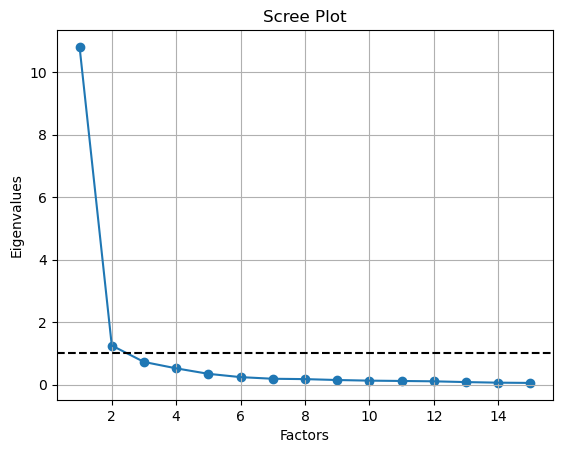

In [28]:
plt.scatter(range(1, df.shape[1]+1), ev)
plt.plot(range(1, df.shape[1]+1), ev)
plt.title('Scree Plot')
plt.xlabel('Factors')
plt.ylabel('Eigenvalues')
plt.axhline(y=1, linestyle='--', color='black')
plt.grid()
plt.show()

In [29]:
alpha = cronbach_alpha(data=df)
alpha

(0.949174399473293, array([0.948, 0.95 ]))

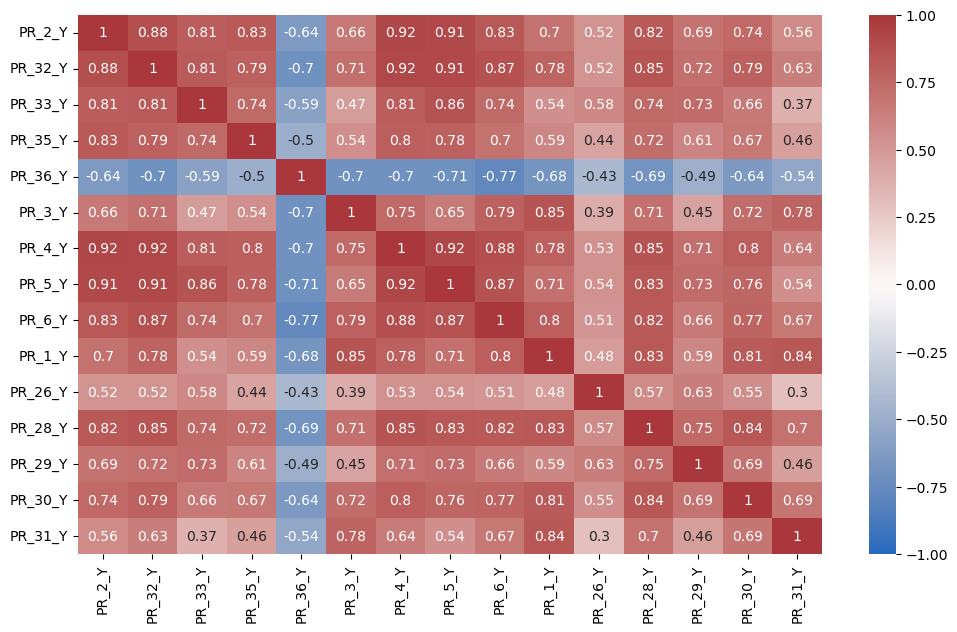

In [30]:
plt.figure(figsize=(12, 7))
sns.heatmap(df.corr(), vmin=-1, vmax=1, annot=True, cmap='vlag');

In [31]:
loadings = pd.DataFrame(fa.loadings_, columns = [f'factor_{i+1}' for i in range(n_factors)], index = [df.columns])
loadings

,factor_1,factor_2
PR_2_Y,0.842129,0.111322
PR_32_Y,0.732506,0.261823
PR_33_Y,1.126528,-0.289024
PR_35_Y,0.811532,0.008887
PR_36_Y,-0.320244,-0.488369
PR_3_Y,-0.071289,0.961703
PR_4_Y,0.730399,0.279710
PR_5_Y,0.908832,0.062485
PR_6_Y,0.523675,0.461151
PR_1_Y,0.023837,0.937893


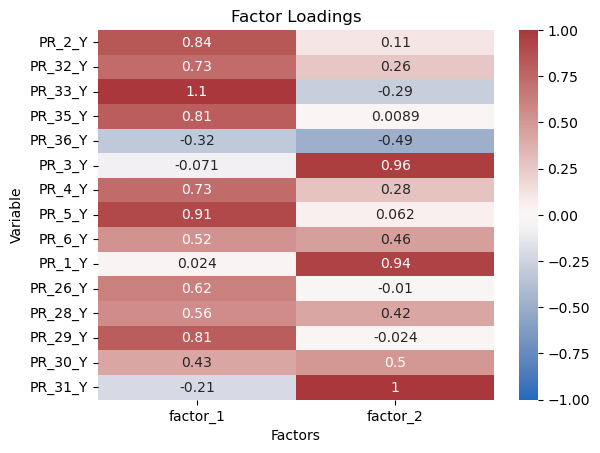

In [32]:
sns.heatmap(loadings, vmin=-1, vmax=1, annot=True, cmap='vlag')
plt.xlabel('Factors')
plt.ylabel('Variable')
plt.title('Factor Loadings');

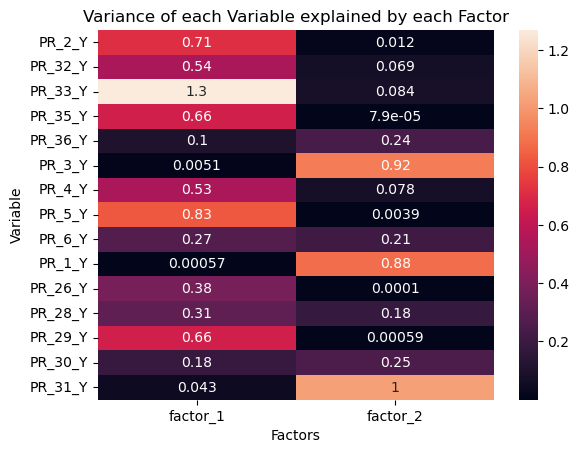

In [33]:
sns.heatmap(loadings.apply(lambda x: x**2), annot=True)
plt.xlabel('Factors')
plt.ylabel('Variable')
plt.title('Variance of each Variable explained by each Factor');

In [34]:
factor_var = pd.DataFrame(fa.get_factor_variance(), columns = [f'factor_{i+1}' for i in range(n_factors)], index=['variance', 
                                                                                                          'proportional_variance', 'cumulative_variance'])
factor_var

,factor_1,factor_2
variance,6.497471,3.960871
proportional_variance,0.433165,0.264058
cumulative_variance,0.433165,0.697223


In [35]:
df.isna().any()

PR_2_Y     False
PR_32_Y    False
PR_33_Y    False
PR_35_Y    False
PR_36_Y    False
PR_3_Y     False
PR_4_Y     False
PR_5_Y     False
PR_6_Y     False
PR_1_Y     False
PR_26_Y    False
PR_28_Y    False
PR_29_Y    False
PR_30_Y    False
PR_31_Y    False
dtype: bool

In [36]:
# df = df[(~df['PR_2_Y'].isna()) & 
#     (~df['PR_3_Y'].isna()) &
#     (~df['PR_4_Y'].isna()) &
#     (~df['PR_32_Y'].isna()) &
#     (~df['PR_35_Y'].isna()) &
#     (~df['PR_26_Y'].isna()) &
#     (~df['PR_1_Y'].isna()) &
#     (~df['PR_30_Y'].isna()) &
#     (~df['PR_26_Y'].isna())]

In [37]:
df.shape

(18014, 15)

In [38]:
data = data.fillna(0)

In [39]:
cppi = pd.DataFrame(fa.transform(df), columns=[f'factor_{i+1}' for i in range(n_factors)], index = df.index)
cppi

,factor_1,factor_2
SVPREC_KEY,,
06001200100,1.021330,2.529577
06001200200,1.163314,2.442429
06001201400,1.503191,2.525127
06001202200,1.985186,2.189327
06001202500,2.237256,2.118699
...,...,...
060395141,-1.120138,-1.530976
060395160,-0.671627,-1.333167
060395183,-0.446408,-0.866520


<Axes: >

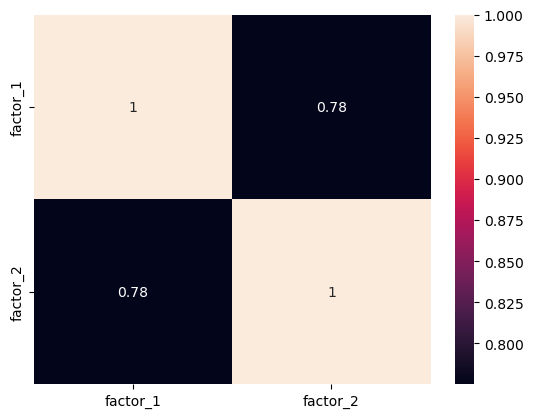

In [40]:
# Correlation between factors
sns.heatmap(cppi.corr(), annot=True)

In [41]:
cppi['factor_1'].mean(), cppi['factor_1'].std(), cppi['factor_1'].min(), cppi['factor_1'].max()

(-2.2088593983882319e-16,
 0.98922268188358,
 -4.2073839737292955,
 3.674737922722991)

In [42]:
cppi['factor_2'].mean(), cppi['factor_2'].std(), cppi['factor_2'].min(), cppi['factor_2'].max()

(8.835437593552927e-17,
 0.9827999866755268,
 -4.214062847569314,
 3.0250051783777785)

In [43]:
# cppi['factor_3'].mean(), cppi['factor_3'].std(), cppi['factor_3'].min(), cppi['factor_3'].max()

In [44]:
# # conditional on only using factor 1
# cppi['cppi'] = (cppi['factor_1'] - cppi['factor_1'].min()) / (cppi['factor_1'].max() - cppi['factor_1'].min())
# cppi

In [45]:
cppi['cppi'] = cppi['factor_1'] + cppi['factor_2']
cppi['cppi_unstd'] = cppi['cppi']
cppi['cppi'] = (cppi['cppi'] - cppi['cppi'].min()) / (cppi['cppi'].max() - cppi['cppi'].min())
cppi

,factor_1,factor_2,cppi,cppi_unstd
SVPREC_KEY,,,,
06001200100,1.021330,2.529577,0.835127,3.550907
06001200200,1.163314,2.442429,0.839162,3.605743
06001201400,1.503191,2.525127,0.870258,4.028318
06001202200,1.985186,2.189327,0.881016,4.174512
06001202500,2.237256,2.118699,0.894368,4.355955
...,...,...,...,...
060395141,-1.120138,-1.530976,0.378739,-2.651114
060395160,-0.671627,-1.333167,0.426300,-2.004794
060395183,-0.446408,-0.866520,0.477212,-1.312928


In [46]:
cppi['cppi'].min(), cppi['cppi'].max(), cppi['cppi'].mean(), cppi['cppi'].std()

(0.0, 1.0, 0.5738266663352689, 0.13671515769305317)

In [47]:
cppi['fips'] = cppi.index.map(lambda x: x[:5])
cppi.head()

,factor_1,factor_2,cppi,cppi_unstd,fips
SVPREC_KEY,,,,,
06001200100,1.021330,2.529577,0.835127,3.550907,06001
06001200200,1.163314,2.442429,0.839162,3.605743,06001
06001201400,1.503191,2.525127,0.870258,4.028318,06001
06001202200,1.985186,2.189327,0.881016,4.174512,06001
06001202500,2.237256,2.118699,0.894368,4.355955,06001


In [48]:
cppi_full = pd.merge(left=cppi.reset_index(), right=full_data, left_on='SVPREC_KEY', right_on='SRPREC_KEY', how='inner')
cppi_full.head()

,SVPREC_KEY,factor_1,factor_2,cppi,cppi_unstd,fips,SRPREC_KEY,PR_1_N,PR_1_Y,PR_26_N,...,PRSLIB01,PRSPAF01,SENDEM01,SENDEM02,SENREP01,SENREP02,USPDEM01,USPREP01,USSDEM01,USSREP01
0,06001200100,1.021330,2.529577,0.835127,3.550907,06001,06001200100,110.394301,2391.379349,1861.799846,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,06001200200,1.163314,2.442429,0.839162,3.605743,06001,06001200200,84.131590,1476.736304,1153.935857,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,06001201400,1.503191,2.525127,0.870258,4.028318,06001,06001201400,103.578871,2247.796796,1672.623802,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,06001202200,1.985186,2.189327,0.881016,4.174512,06001,06001202200,23.911917,251.075125,172.365066,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,06001202500,2.237256,2.118699,0.894368,4.355955,06001,06001202500,21.736580,229.559095,124.916878,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [49]:
cppi_full.shape, full_data.shape

((18014, 162), (20060, 156))

In [50]:
# EDA
cnty_cppi = cppi.groupby(['fips'])['factor_1'].agg(['median'])# .sort_values(['median'], ascending=False)
cnty_cppi

,median
fips,
06001,0.781769
06003,0.687491
06005,-1.184600
06007,-0.398984
06009,-1.243878
06011,-1.297419
06013,0.108863
06015,-0.467417
06017,-1.212806


In [51]:
cnty_f1 = {}
cnty_f2 = {}
cnty_cppi = {}

# cnty_f3 = {}

for i in np.unique(cppi['fips'].values):
    cnty_df = cppi_full[cppi_full['fips'] == i]
    cnty_df['CVAP_23'] = cnty_df['CVAP_23'] / cnty_df['CVAP_23'].sum()
    weighted_avg_f1 = np.sum(cnty_df['CVAP_23'] * cnty_df['factor_1'].map(lambda x: x + abs(cnty_df['factor_1'].min()))) - abs(cnty_df['factor_1'].min())
    weighted_avg_f2 = np.sum(cnty_df['CVAP_23'] * cnty_df['factor_2'].map(lambda x: x + abs(cnty_df['factor_2'].min()))) - abs(cnty_df['factor_2'].min())
    weighted_avg_cppi = np.sum(cnty_df['CVAP_23'] * cnty_df['cppi'])
    cnty_f1.update({i: weighted_avg_f1})
    cnty_f2.update({i: weighted_avg_f2})
    cnty_cppi.update({i: weighted_avg_cppi})
    #weighted_avg_f3 = np.sum(cnty_df['G24PTot'] * cnty_df['factor_3'].map(lambda x: x + abs(cnty_df['factor_3'].min()))) - abs(cnty_df['factor_3'].min())
    #cnty_f3.update({i: weighted_avg_f3})

cnty_cppi

{'06001': 0.7314197990036679,
 '06003': 0.6845654181936294,
 '06005': 0.4219999420243439,
 '06007': 0.5460661683641199,
 '06009': 0.41688336577662444,
 '06011': 0.42288843166264356,
 '06013': 0.654432496031432,
 '06015': 0.4717095583279754,
 '06017': 0.45256268850030634,
 '06019': 0.5299010147515746,
 '06021': 0.4144465616947286,
 '06023': 0.6615577708865356,
 '06025': 0.5754488761388634,
 '06027': 0.5404015642579423,
 '06029': 0.49570991524226626,
 '06031': 0.47645758015965956,
 '06033': 0.5483684648934867,
 '06035': 0.35929012219562145,
 '06037': 0.6567304322368449,
 '06039': 0.4755458172335311,
 '06041': 0.7163336965112918,
 '06043': 0.4779086278001205,
 '06045': 0.6397070875429189,
 '06047': 0.5444630274357625,
 '06049': 0.3582466098080787,
 '06051': 0.6227312662785843,
 '06053': 0.6510137565616905,
 '06055': 0.6257104007444934,
 '06057': 0.5560615589701443,
 '06059': 0.540902483405084,
 '06061': 0.46202850054419775,
 '06063': 0.4680007918461453,
 '06065': 0.5403190886891139,
 '060

In [52]:
cnty_df = cppi_full.copy()
cnty_df['CVAP_23'] = cnty_df['CVAP_23'] / cnty_df['CVAP_23'].sum()
weighted_avg_f1 = np.sum(cnty_df['CVAP_23'] * cnty_df['factor_1'].map(lambda x: x + abs(cnty_df['factor_1'].min()))) - abs(cnty_df['factor_1'].min())
weighted_avg_f2 = np.sum(cnty_df['CVAP_23'] * cnty_df['factor_2'].map(lambda x: x + abs(cnty_df['factor_2'].min()))) - abs(cnty_df['factor_2'].min())
weighted_avg_cppi = np.sum(cnty_df['CVAP_23'] * cnty_df['cppi'])
print(f'Weighted avg factor 1: {weighted_avg_f1}')
print(f'Weighted avg factor 2: {weighted_avg_f2}')
print(f'Weighted avg CSII: {weighted_avg_cppi}')

Weighted avg factor 1: 0.1981181987245746
Weighted avg factor 2: 0.2191219568469469
Weighted avg CSII: 0.6045300699181109


In [53]:
cnty_f1 = pd.DataFrame(cnty_f1, index=[0]).T.reset_index().rename({'index': 'fips', 0: 'avg_f1'}, axis=1)
cnty_f2 = pd.DataFrame(cnty_f2, index=[1]).T.reset_index().rename({'index': 'fips', 1: 'avg_f2'}, axis=1)
cnty_cppi = pd.DataFrame(cnty_cppi, index=[2]).T.reset_index().rename({'index': 'fips', 2: 'cppi'}, axis=1)
cnty_cppi = pd.merge(left=cnty_cppi, right=cnty_f1, on='fips', how='inner')
cnty_cppi = pd.merge(left=cnty_cppi, right=cnty_f2, on='fips', how='inner')
#cnty_cppi = pd.merge(left=cnty_cppi, right=cnty_f3, on='fips', how='inner')
cnty_cppi.head()

,fips,cppi,avg_f1,avg_f2
0,06001,0.731420,0.911684,1.229909
1,06003,0.684565,0.754665,0.750205
2,06005,0.422000,-1.126981,-0.936249
3,06007,0.546066,-0.158990,-0.218258
4,06009,0.416883,-1.165070,-0.967692


In [54]:
def getCounties():
    "Function to return a dict of FIPS codes (keys) of U.S. counties (values)"
    d = {}
    r = requests.get("http://www2.census.gov/geo/docs/reference/codes/files/national_county.txt")
    reader = csv.reader(r.text.splitlines(), delimiter=',')    
    for line in reader:
        d[line[1] + line[2]] = line[3].replace(" County","")    
    return d

cnty_df = pd.DataFrame(getCounties(), index=[0]).T.reset_index().rename({'index': 'fips', 0:'cnty_name'}, axis=1)
cnty_df.head()

,fips,cnty_name
0,01001,Autauga
1,01003,Baldwin
2,01005,Barbour
3,01007,Bibb
4,01009,Blount


In [55]:
cnty_cppi = pd.merge(left=cnty_cppi, right=cnty_df, on='fips', how='inner')
cnty_cppi.head()

,fips,cppi,avg_f1,avg_f2,cnty_name
0,06001,0.731420,0.911684,1.229909,Alameda
1,06003,0.684565,0.754665,0.750205,Alpine
2,06005,0.422000,-1.126981,-0.936249,Amador
3,06007,0.546066,-0.158990,-0.218258,Butte
4,06009,0.416883,-1.165070,-0.967692,Calaveras


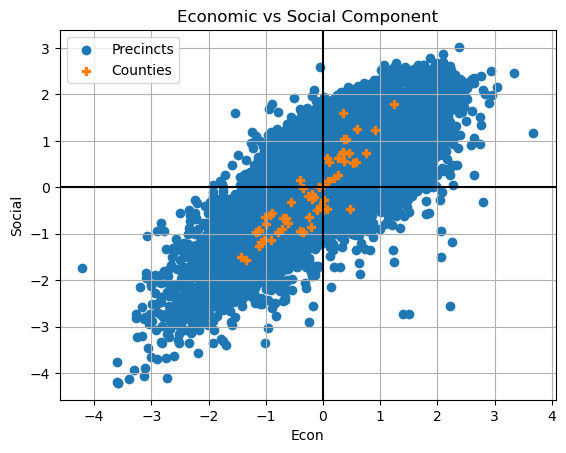

In [56]:
plt.scatter(cppi['factor_1'], cppi['factor_2'], label='Precincts')
plt.scatter(cnty_cppi['avg_f1'], cnty_cppi['avg_f2'], marker='P', label='Counties')
plt.xlabel('Econ')
plt.ylabel('Social')
plt.title('Economic vs Social Component')
plt.axhline(0, color='black')
plt.axvline(0, color='black')
plt.grid()
plt.legend();

In [57]:
cppi_full.columns.values

array(['SVPREC_KEY', 'factor_1', 'factor_2', 'cppi', 'cppi_unstd', 'fips',
       'SRPREC_KEY', 'PR_1_N', 'PR_1_Y', 'PR_26_N', 'PR_26_Y', 'PR_27_N',
       'PR_27_Y', 'PR_28_N', 'PR_28_Y', 'PR_29_N', 'PR_29_Y', 'PR_30_N',
       'PR_30_Y', 'PR_31_N', 'PR_31_Y', 'PR_1_TOT', 'PR_26_TOT',
       'PR_27_TOT', 'PR_28_TOT', 'PR_29_TOT', 'PR_30_TOT', 'PR_31_TOT',
       'CIT_23', 'NH_CIT_23', 'NH_Ind_CIT_23', 'NH_Asn_CIT_23',
       'NH_Blk_CIT_23', 'NH_Hwn_CIT_23', 'NH_Wht_CIT_23',
       'NH_IndWht_CIT_23', 'NH_AsnWht_CIT_23', 'NH_BlkWht_CIT_23',
       'NH_IndBlk_CIT_23', 'NH_OthMR_CIT_23', 'Hsp_CIT_23', 'CVAP_23',
       'NH_CVAP_23', 'NH_Ind_CVAP_23', 'NH_Asn_CVAP_23', 'NH_Blk_CVAP_23',
       'NH_Hwn_CVAP_23', 'NH_Wht_CVAP_23', 'NH_IndWht_CVAP_23',
       'NH_AsnWht_CVAP_23', 'NH_BlkWht_CVAP_23', 'NH_IndBlk_CVAP_23',
       'NH_OthMR_CVAP_23', 'Hsp_CVAP_23', 'DOJ_NH_Ind_CIT_23',
       'DOJ_NH_Ind_CVAP_23', 'DOJ_NH_Blk_CIT_23', 'DOJ_NH_Blk_CVAP_23',
       'DOJ_NH_Asn_CIT_23', 'DOJ_NH_A

In [58]:
cppi.columns.values

array(['factor_1', 'factor_2', 'cppi', 'cppi_unstd', 'fips'], dtype=object)

In [59]:
# metric = 'factor_1'
# race = 'G24PR5'

# race_tot = cppi_full[f'{race}_Y'] + cppi_full[f'{race}_N']

# model = lm.LinearRegression().fit(cppi_full[[metric]].values, (cppi_full[f'{race}_Y'] / race_tot).values)
# r = r_regression(cppi_full[[metric]], cppi_full[f'{race}_Y'] / race_tot)
# print(f'Coefficient: {model.coef_}, Intercept: {model.intercept_}')
# print(f'r = {r}')

# if metric == 'cppi':
#     x = np.linspace(0, 1, 10000)
# else:
#     x = np.linspace(-4, 4, 20000)

# plt.scatter(cppi_full[metric], cppi_full[f'{race}_Y'] / race_tot, alpha=0.1, s=30)
# plt.plot(x, model.coef_[0]*x + model.intercept_, color='red')
# plt.xlabel(metric)
# plt.ylabel(race)
# plt.title(f'{metric} vs {race}');

In [60]:
cppi_full['G24PTot'] = cppi_full['G24PDem'] + cppi_full['G24PRep'] + cppi_full['G24POth']

Coefficient: [0.08277926], Intercept: 0.5456745916757647
r = [0.91192531]


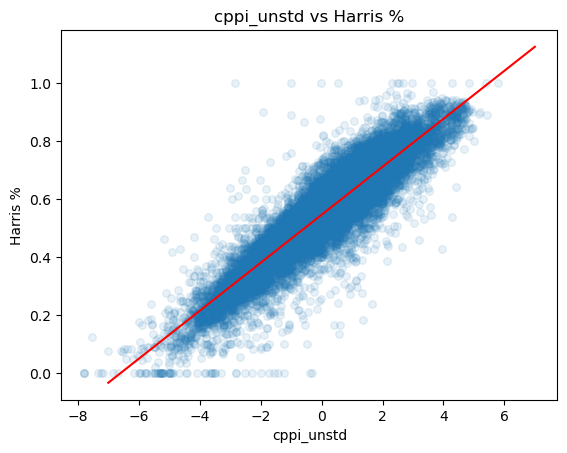

In [61]:
metric = 'cppi_unstd'
race = 'G24PDem'

race_pct = cppi_full[race] / cppi_full['G24PTot']

model = lm.LinearRegression().fit(cppi_full[[metric]].values, race_pct.values)
r = r_regression(cppi_full[[metric]], race_pct)
print(f'Coefficient: {model.coef_}, Intercept: {model.intercept_}')
print(f'r = {r}')

if metric == 'cppi':
    x = np.linspace(0, 1, 10000)
elif metric == 'cppi_unstd':
    x = np.linspace(-7, 7, 20000)
else:
    x = np.linspace(-4, 4, 20000)

plt.scatter(cppi_full[metric], race_pct, alpha=0.1, s=30)
plt.plot(x, model.coef_[0]*x + model.intercept_, color='red')
plt.xlabel(metric)
plt.ylabel('Harris %')
plt.title(f'{metric} vs Harris %');

In [62]:
## The actual IWAR/VAIR model

In [63]:
cppi_full['P24_margin'] = cppi_full['G24PDem'] - cppi_full['G24PRep']
metric = 'cppi_unstd'
race = 'P24_margin'

race_pct = cppi_full[race] / cppi_full['G24PTot']
cppi_full['P24_margin'] = race_pct

In [64]:
def logistic(x, params):
    A, B, C, K, Q, v = params
    y = A + (K - A)/((C + Q*np.exp(-B*x))**(1/v))
    return y

def logistic_fixed(x, B, C, Q, v):
    params = [-1, B, C, 2, Q, v]
    return logistic(x, params)

def loss_fun(x, y, B, C, Q, v):
    params = [-1, B, C, 2, Q, v]
    logistic_res = logistic(x, params)
    loss = np.sum((logistic_res - y)**2) * 1 / logistic_res.shape[0]
    return loss

def rmse(x, y, B, C, Q, v):
    params = [-1, B, C, 2, Q, v]
    logistic_res = logistic(x, params)
    loss = np.sum((logistic_res - y)**2) * 1 / logistic_res.shape[0]
    return np.sqrt(loss)

In [65]:
# x0 = [0.5, 1, 1, 1]
# params = opt.fmin(loss_fun, x0=x0)
# B, C, Q, v = params
# B, C, Q, v, loss_fun(params)

In [66]:
X = cppi_full[[metric]]
y = race_pct
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

def kfold_cv(X_train, y_train, x0, bounds, k=5):
    kf = KFold(n_splits=k)
    losses = []
    rmse = []
    for i, (train_index, test_index) in enumerate(kf.split(X_train)):
        X_fold_train, y_fold_train, X_val, y_val = X_train[metric].values[train_index], y_train.values[train_index], X_train[metric].values[test_index], y_train.values[test_index]
        params, cov = opt.curve_fit(logistic_fixed, X_fold_train, y_fold_train, p0=x0, bounds=bounds)
        B, C, Q, v = params
        val_loss = loss_fun(X_val, y_val, B, C, Q, v)
        losses.append(val_loss)
        rmse.append(np.sqrt(val_loss))
    return losses, rmse

In [67]:
x0 = [0.5, 1, 1, 1]
bounds = ([-np.inf, -np.inf, -np.inf, 0], np.inf)
kfold_losses, kfold_rmses = kfold_cv(X_train, y_train, x0=x0, bounds=bounds, k=5)
print(f'K-Fold CV L2 losses: {kfold_losses}')
print(f"K-Fold CV L2 RMSE's: {kfold_rmses}")

params, cov = opt.curve_fit(logistic_fixed, X_train[metric], y_train, p0=x0, bounds=bounds, full_output=False)
B, C, Q, v = params
print(f'B = {B}, C = {C}, Q = {Q}, v = {v}')
print(f'Training set loss: {loss_fun(X_train[metric], y_train, B, C, Q, v)},\n test set loss: {loss_fun(X_test[metric], y_test, B, C, Q, v)}')
print(f'Training set RMSE: {rmse(X_train[metric], y_train, B, C, Q, v)},\n test set RMSE: {rmse(X_test[metric], y_test, B, C, Q, v)}')
print(f'Total loss: {loss_fun(X[metric], y, B, C, Q, v)}')
print(f'Total RMSE: {rmse(X[metric], y, B, C, Q, v)}')

K-Fold CV L2 losses: [0.021571892877637878, 0.01812088278302953, 0.019264372726259686, 0.0191658524596024, 0.01690252081181124]
K-Fold CV L2 RMSE's: [0.1468737310673283, 0.134613828349949, 0.13879615530071315, 0.1384407904470442, 0.1300096950685265]
B = 0.21431959562337544, C = 1.00003286754782, Q = 9.34742720638542e-05, v = 0.00013010520752870254
Training set loss: 0.018992680999699918,
 test set loss: 0.018194092403273004
Training set RMSE: 0.13781393615922855,
 test set RMSE: 0.13488547884510402
Total loss: 0.01872912991688888
Total RMSE: 0.13685441138994708


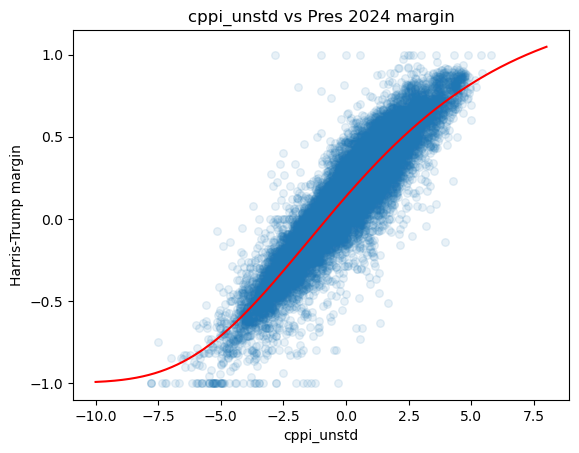

In [68]:
if metric == 'cppi':
    x = np.linspace(0, 1, 10000)
elif metric == 'cppi_unstd':
    x = np.linspace(-10, 8, 20000)
else:
    x = np.linspace(-4, 4, 20000)

plt.scatter(cppi_full[metric], race_pct, alpha=0.1, s=30)
plt.plot(x, logistic_fixed(x, B, C, Q, v), color='red')
plt.xlabel(metric)
plt.ylabel('Harris-Trump margin')
plt.title(f'{metric} vs Pres 2024 margin');

In [69]:
logistic(0, [-1, B, C, 2, Q, v])

0.13609773804845848

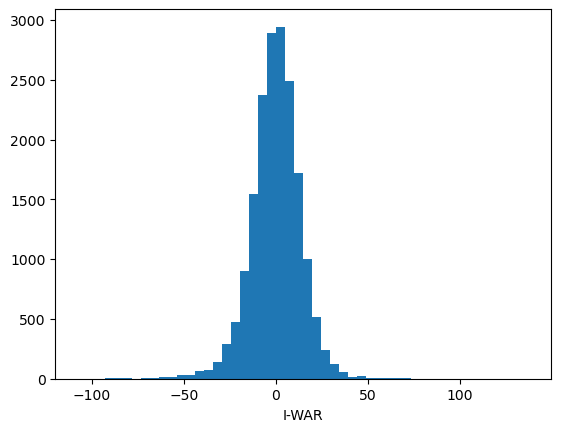

In [70]:
# We can create a sort of Harris ideological WAR (I-WAR) metric based on this
pred_margin = logistic(cppi_full[metric], [-1, B, C, 2, Q, v])
cppi_full['iwar'] = (cppi_full['P24_margin'] - pred_margin) * 100
cppi = pd.merge(left=cppi.reset_index(), right=cppi_full[['SVPREC_KEY', 'iwar']], on='SVPREC_KEY').set_index(['SVPREC_KEY'])
plt.hist(cppi_full['iwar'], bins=50)
plt.xlabel('I-WAR');

In [71]:
cppi_full['iwar']

0        19.400625
1        17.961151
2        14.947707
3         4.955409
4        -5.040802
           ...    
18009     1.497880
18010   -14.540134
18011   -16.427512
18012   -15.862622
18013    -5.347635
Name: iwar, Length: 18014, dtype: float64

In [72]:
cppi_full.columns.values

array(['SVPREC_KEY', 'factor_1', 'factor_2', 'cppi', 'cppi_unstd', 'fips',
       'SRPREC_KEY', 'PR_1_N', 'PR_1_Y', 'PR_26_N', 'PR_26_Y', 'PR_27_N',
       'PR_27_Y', 'PR_28_N', 'PR_28_Y', 'PR_29_N', 'PR_29_Y', 'PR_30_N',
       'PR_30_Y', 'PR_31_N', 'PR_31_Y', 'PR_1_TOT', 'PR_26_TOT',
       'PR_27_TOT', 'PR_28_TOT', 'PR_29_TOT', 'PR_30_TOT', 'PR_31_TOT',
       'CIT_23', 'NH_CIT_23', 'NH_Ind_CIT_23', 'NH_Asn_CIT_23',
       'NH_Blk_CIT_23', 'NH_Hwn_CIT_23', 'NH_Wht_CIT_23',
       'NH_IndWht_CIT_23', 'NH_AsnWht_CIT_23', 'NH_BlkWht_CIT_23',
       'NH_IndBlk_CIT_23', 'NH_OthMR_CIT_23', 'Hsp_CIT_23', 'CVAP_23',
       'NH_CVAP_23', 'NH_Ind_CVAP_23', 'NH_Asn_CVAP_23', 'NH_Blk_CVAP_23',
       'NH_Hwn_CVAP_23', 'NH_Wht_CVAP_23', 'NH_IndWht_CVAP_23',
       'NH_AsnWht_CVAP_23', 'NH_BlkWht_CVAP_23', 'NH_IndBlk_CVAP_23',
       'NH_OthMR_CVAP_23', 'Hsp_CVAP_23', 'DOJ_NH_Ind_CIT_23',
       'DOJ_NH_Ind_CVAP_23', 'DOJ_NH_Blk_CIT_23', 'DOJ_NH_Blk_CVAP_23',
       'DOJ_NH_Asn_CIT_23', 'DOJ_NH_A

In [73]:
cnty_iwar = {}

for i in np.unique(cppi['fips'].values):
    cnty_df = cppi_full[cppi_full['fips'] == i]
    cnty_df['G24PTot'] = cnty_df['G24PTot'] / cnty_df['G24PTot'].sum()
    weighted_avg_iwar = np.sum(cnty_df['G24PTot'] * cnty_df['iwar'])
    cnty_iwar.update({i: weighted_avg_iwar})
    #weighted_avg_f3 = np.sum(cnty_df['G24PTot'] * cnty_df['factor_3'].map(lambda x: x + abs(cnty_df['factor_3'].min()))) - abs(cnty_df['factor_3'].min())
    #cnty_f3.update({i: weighted_avg_f3})

cnty_iwar

{'06001': 7.829247090785008,
 '06003': -2.1487196437314555,
 '06005': -3.495641322047577,
 '06007': -5.622150742009792,
 '06009': -4.433456243752731,
 '06011': -4.309942928828826,
 '06013': 7.28947575553947,
 '06015': -3.082680703802292,
 '06017': 2.905191823863825,
 '06019': -0.6673997693645475,
 '06021': -6.667471534047915,
 '06023': -2.4599019725303397,
 '06025': -13.565789787113985,
 '06027': -3.14950996426974,
 '06029': -8.759692713388121,
 '06031': -8.589366023757758,
 '06033': -8.933102248343666,
 '06035': -13.048555586633865,
 '06037': 3.278211607904753,
 '06039': -3.93841646477316,
 '06041': 18.871515232237908,
 '06043': -3.9207083943428453,
 '06045': -2.7492864445348073,
 '06047': -7.719671688201508,
 '06049': -7.417431718575334,
 '06051': -0.27111330235185077,
 '06053': -0.24447887609934105,
 '06055': 10.397916503552157,
 '06057': 2.0462304053586307,
 '06059': 0.8038211853646111,
 '06061': 4.254710601310865,
 '06063': -3.085729686992131,
 '06065': -4.093904736627176,
 '06067

In [74]:
cnty_iwar = pd.DataFrame(cnty_iwar, index=[3]).T.reset_index().rename({'index': 'fips', 3: 'iwar'}, axis=1)
cnty_cppi = pd.merge(left=cnty_cppi, right=cnty_iwar, on='fips')
cnty_cppi.head()

,fips,cppi,avg_f1,avg_f2,cnty_name,iwar
0,06001,0.731420,0.911684,1.229909,Alameda,7.829247
1,06003,0.684565,0.754665,0.750205,Alpine,-2.148720
2,06005,0.422000,-1.126981,-0.936249,Amador,-3.495641
3,06007,0.546066,-0.158990,-0.218258,Butte,-5.622151
4,06009,0.416883,-1.165070,-0.967692,Calaveras,-4.433456


In [75]:
cppi.head()

,factor_1,factor_2,cppi,cppi_unstd,fips,iwar
SVPREC_KEY,,,,,,
06001200100,1.021330,2.529577,0.835127,3.550907,06001,19.400625
06001200200,1.163314,2.442429,0.839162,3.605743,06001,17.961151
06001201400,1.503191,2.525127,0.870258,4.028318,06001,14.947707
06001202200,1.985186,2.189327,0.881016,4.174512,06001,4.955409
06001202500,2.237256,2.118699,0.894368,4.355955,06001,-5.040802


In [76]:
cppi[cppi.index.map(lambda x: x[:5]) == '06039']

,factor_1,factor_2,cppi,cppi_unstd,fips,iwar
SVPREC_KEY,,,,,,
060391003,-0.983240,-1.114094,0.419490,-2.097334,06039,2.149249
060391020,-1.679858,-1.775693,0.319543,-3.455552,06039,-1.384978
060391027,-1.480512,-1.676316,0.341525,-3.156829,06039,2.861655
060391031,-1.277760,-1.630073,0.359848,-2.907832,06039,-15.155068
060391101,0.587652,-0.429710,0.585449,0.157942,06039,-6.547558
...,...,...,...,...,...,...
060395141,-1.120138,-1.530976,0.378739,-2.651114,06039,1.497880
060395160,-0.671627,-1.333167,0.426300,-2.004794,06039,-14.540134
060395183,-0.446408,-0.866520,0.477212,-1.312928,06039,-16.427512


In [77]:
df.columns

Index(['PR_2_Y', 'PR_32_Y', 'PR_33_Y', 'PR_35_Y', 'PR_36_Y', 'PR_3_Y',
       'PR_4_Y', 'PR_5_Y', 'PR_6_Y', 'PR_1_Y', 'PR_26_Y', 'PR_28_Y', 'PR_29_Y',
       'PR_30_Y', 'PR_31_Y'],
      dtype='object')

In [78]:
data.head()

,PR_2_Y,PR_32_Y,PR_33_Y,PR_34_Y,PR_35_Y,PR_36_Y,PR_3_Y,PR_4_Y,PR_5_Y,PR_6_Y,...,NH_BlkWht_CVAP_23,NH_IndBlk_CVAP_23,NH_OthMR_CVAP_23,Hsp_CVAP_23,DOJ_NH_Ind_CIT_23,DOJ_NH_Ind_CVAP_23,DOJ_NH_Blk_CIT_23,DOJ_NH_Blk_CVAP_23,DOJ_NH_Asn_CIT_23,DOJ_NH_Asn_CVAP_23
SVPREC_KEY,,,,,,,,,,,,,,,,,,,,,
06001200100,0.808414,0.747525,0.312950,0.401340,0.773941,0.478416,0.936986,0.851100,0.629434,0.754941,...,49,0,13,165,4,4,133,122,700,551
06001200200,0.803354,0.745623,0.372313,0.380798,0.757449,0.462141,0.929746,0.845148,0.653230,0.757292,...,2,12,9,410,17,17,212,163,1167,1079
06001201400,0.848705,0.787456,0.420717,0.384644,0.778610,0.424189,0.936925,0.874056,0.718925,0.790689,...,13,18,13,565,21,21,184,166,1350,1224
06001202200,0.847291,0.813602,0.590078,0.376344,0.798956,0.367609,0.911111,0.863184,0.760101,0.820051,...,3,5,7,54,0,0,22,21,223,213
06001202500,0.856916,0.759740,0.647255,0.477002,0.818923,0.385484,0.910494,0.899371,0.786624,0.765189,...,14,0,15,810,62,62,183,183,1408,1374


In [79]:
np.unique(data.index.map(lambda x: x[:5]))

array(['06001', '06003', '06005', '06007', '06009', '06011', '06013',
       '06015', '06017', '06019', '06021', '06023', '06025', '06027',
       '06029', '06031', '06033', '06035', '06037', '06039', '06041',
       '06043', '06045', '06047', '06049', '06051', '06053', '06055',
       '06057', '06059', '06061', '06063', '06065', '06067', '06069',
       '06071', '06073', '06075', '06077', '06079', '06081', '06083',
       '06085', '06087', '06089', '06091', '06093', '06095', '06097',
       '06099', '06101', '06103', '06105', '06107', '06109', '06111',
       '06113', '06115'], dtype=object)

In [80]:
# cppi = cppi.reset_index()

# data_nomad = cppi[~(cppi['SVPREC_KEY'].map(lambda x: x[:5]) == '06039')]
# data_mad = cppi[(cppi['SVPREC_KEY'].map(lambda x: x[:5]) == '06039')]
# data_mad['SVPREC_KEY'] = data_mad['SVPREC_KEY'].map(lambda x: '06039000' + x[5:])

# cppi = pd.concat([data_nomad, data_mad], axis=0)
# cppi = cppi.set_index(['SVPREC_KEY'])

In [81]:
madera = cppi.reset_index()
madera = madera[madera['SVPREC_KEY'].map(lambda x: x[:5]) == '06039']
madera['SRPREC'] = madera['SVPREC_KEY'].map(lambda x: x[5:])
madera.head()

,SVPREC_KEY,factor_1,factor_2,cppi,cppi_unstd,fips,iwar,SRPREC
17953,060391003,-0.983240,-1.114094,0.419490,-2.097334,06039,2.149249,1003
17954,060391020,-1.679858,-1.775693,0.319543,-3.455552,06039,-1.384978,1020
17955,060391027,-1.480512,-1.676316,0.341525,-3.156829,06039,2.861655,1027
17956,060391031,-1.277760,-1.630073,0.359848,-2.907832,06039,-15.155068,1031
17957,060391101,0.587652,-0.429710,0.585449,0.157942,06039,-6.547558,1101


In [82]:
cppi_full.columns.values

array(['SVPREC_KEY', 'factor_1', 'factor_2', 'cppi', 'cppi_unstd', 'fips',
       'SRPREC_KEY', 'PR_1_N', 'PR_1_Y', 'PR_26_N', 'PR_26_Y', 'PR_27_N',
       'PR_27_Y', 'PR_28_N', 'PR_28_Y', 'PR_29_N', 'PR_29_Y', 'PR_30_N',
       'PR_30_Y', 'PR_31_N', 'PR_31_Y', 'PR_1_TOT', 'PR_26_TOT',
       'PR_27_TOT', 'PR_28_TOT', 'PR_29_TOT', 'PR_30_TOT', 'PR_31_TOT',
       'CIT_23', 'NH_CIT_23', 'NH_Ind_CIT_23', 'NH_Asn_CIT_23',
       'NH_Blk_CIT_23', 'NH_Hwn_CIT_23', 'NH_Wht_CIT_23',
       'NH_IndWht_CIT_23', 'NH_AsnWht_CIT_23', 'NH_BlkWht_CIT_23',
       'NH_IndBlk_CIT_23', 'NH_OthMR_CIT_23', 'Hsp_CIT_23', 'CVAP_23',
       'NH_CVAP_23', 'NH_Ind_CVAP_23', 'NH_Asn_CVAP_23', 'NH_Blk_CVAP_23',
       'NH_Hwn_CVAP_23', 'NH_Wht_CVAP_23', 'NH_IndWht_CVAP_23',
       'NH_AsnWht_CVAP_23', 'NH_BlkWht_CVAP_23', 'NH_IndBlk_CVAP_23',
       'NH_OthMR_CVAP_23', 'Hsp_CVAP_23', 'DOJ_NH_Ind_CIT_23',
       'DOJ_NH_Ind_CVAP_23', 'DOJ_NH_Blk_CIT_23', 'DOJ_NH_Blk_CVAP_23',
       'DOJ_NH_Asn_CIT_23', 'DOJ_NH_A

In [83]:
for col in ['NH_Ind_CVAP_23', 'NH_Asn_CVAP_23', 'NH_Blk_CVAP_23',
       'NH_Hwn_CVAP_23', 'NH_Wht_CVAP_23', 'NH_IndWht_CVAP_23',
       'NH_AsnWht_CVAP_23', 'NH_BlkWht_CVAP_23', 'NH_IndBlk_CVAP_23',
       'NH_OthMR_CVAP_23', 'Hsp_CVAP_23']:
    cppi_full[f'{col}_pct'] = cppi_full[col] / cppi_full['CVAP_23'] * 100

In [173]:
# cppi_full[cppi_full['Hsp_CVAP_23_pct'] >= 600][['CVAP_23',
#        'NH_CVAP_23', 'NH_Ind_CVAP_23', 'NH_Asn_CVAP_23', 'NH_Blk_CVAP_23',
#        'NH_Hwn_CVAP_23', 'NH_Wht_CVAP_23', 'NH_IndWht_CVAP_23',
#        'NH_AsnWht_CVAP_23', 'NH_BlkWht_CVAP_23', 'NH_IndBlk_CVAP_23',
#        'NH_OthMR_CVAP_23', 'Hsp_CVAP_23', 'DOJ_NH_Ind_CIT_23',
#        'DOJ_NH_Ind_CVAP_23', 'DOJ_NH_Blk_CIT_23', 'DOJ_NH_Blk_CVAP_23',
#        'DOJ_NH_Asn_CIT_23', 'DOJ_NH_Asn_CVAP_23']]

(-120.08686702362907, 149.9039067833143)

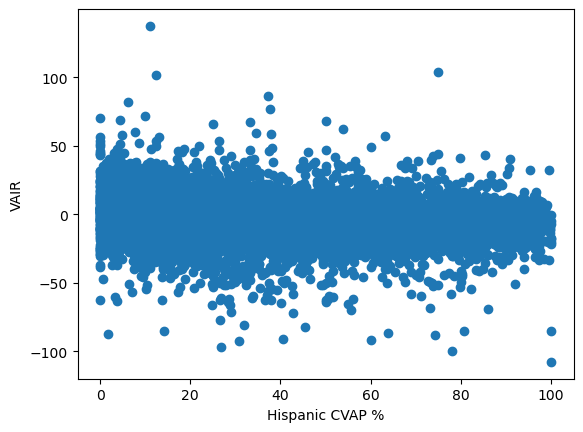

In [85]:
plt.scatter(cppi_full['Hsp_CVAP_23_pct'], cppi_full['iwar'])
plt.xlabel('Hispanic CVAP %')
plt.ylabel('VAIR')
plt.ylim()

In [86]:
cnty_cppi.to_csv('county_cppi/cnty_cppi.csv', index=False)
cppi.to_csv('cppi/cppi.csv')
madera.to_csv('cppi/cppi_c06039.csv')